Early Stages of the file. Pulling Game comments

In [77]:
import requests
from lxml import etree
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

In [82]:
sns.set(rc={'figure.figsize':(10,8)})

In [3]:
con = sqlite3.connect('bgg.db')
cur = con.cursor()

In [19]:
params = {'id' : '246192','stats' :'0'}
response = requests.get('https://www.boardgamegeek.com/xmlapi2/thing?', params)
soup = BeautifulSoup(response.text, "xml")
str_ = str(soup.find('description'))

In [22]:
str_ = str_.replace('<description>', '')
str_ = str_.replace('</description>', '')
str_

"The smartest minds of our generation are gathering together at the Great Science Fair. Everyone's been working hard on their creations, but only one will be crowned champion. Contestants have to think on the fly to build their machines quickly and efficiently. Whose project will be the best?&amp;#10;&amp;#10;In Gizmos, you win the game by gaining victory points from building engines. And engines help you get things done faster. Whoever builds the greatest machine and collects the most victory points wins!&amp;#10;&amp;#10;At the beginning of the game, you have 4 actions:&amp;#10;&amp;#10;     File : Put a card in the public to your Archive, allow you to build it later.&amp;#10;     Pick : Take one energy marble from the 3D marble dispenser, to your storage.&amp;#10;     Build : Build one machine and put it on action! You have to pay the marbles with colors corresponding to the card cost.&amp;#10;     Research : Draw some cards, and you can then File or Build one of the drawn cards. Th

In [51]:
comment_len = 1
comment_li = []
i = 1
game_id = '246192'
while comment_len > 0:
    params = {'id' : game_id,'comments' :'1', 'page' : str(i), 'pagesize' : str(100)}
    response = requests.get('https://www.boardgamegeek.com/xmlapi2/thing?', params)
    soup = BeautifulSoup(response.text, "xml")
    comments = soup.find_all('comment')
    for idx, com in enumerate(comments):
        comment_li.append((game_id, com['rating'], com['username'], com['value']))
    comment_len = len(comments)
    i += 1

In [63]:
df = pd.DataFrame(comment_li, columns = ['game_id', 'rating','user','description'])
df.shape

(1190, 4)

In [64]:
# Convert rating to a number
df.loc[df['rating'] == 'N/A', 'rating'] = np.nan
df.loc[:, 'rating'] = df.loc[:, 'rating'].astype(float)

In [71]:
unrated, high, low = df[pd.isna(df['rating'])].shape[0], df[df['rating'] >= 7].shape[0], df[df['rating'] < 7].shape[0]
print(unrated, high, low)

283 715 192


Text(0.5, 1.0, 'Cumulative Distribution of Scores')

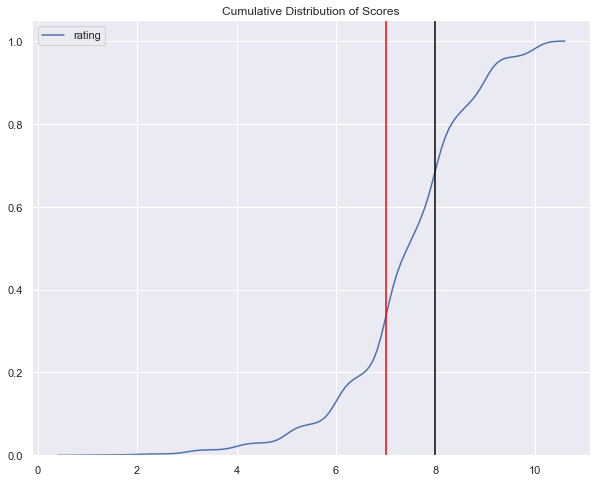

In [87]:
sns.kdeplot(df.loc[df['rating']>0, 'rating'], cumulative=True)
plt.axvline(8, 0, 1, color ='black')
plt.axvline(7, 0, 1, color ='red')
plt.title('Cumulative Distribution of Scores')